In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import pickle


In [2]:
def save_dataset(parts,dataset,original_path,prefix):
  num_elem = int(len(dataset)/parts) + 1
  for n in range(parts):
    if n < parts - 1:
      path = open(original_path + prefix + "{}_{}.pkl".format(num_elem*n,num_elem*(n+1)), "wb")
      pickle.dump(dataset[num_elem*n:num_elem*(n+1)], path)
    else:
      path = open(original_path + prefix + "{}_{}.pkl".format(num_elem*n,len(dataset)), "wb")
      pickle.dump(dataset[num_elem*n:], path)
    print(prefix + " part{} is save".format(n))
  path.close() 

In [3]:
def FirstLoadSave(parts,BATCH_SIZE,original_path,prefix,BOOL):
	# load dataset
  datagen = ImageDataGenerator(rescale=1./255)
  X = datagen.flow_from_directory('/content/drive/MyDrive/HK5/Project_1/Đồ án số 1 khoa học dữ liệu/Dataset/Train',
                                  target_size = (224,224),
                                  batch_size = BATCH_SIZE,
                                  class_mode='sparse')
  if (BOOL):
    #Save dataset
    dataset = list()
    for i in range(len(X)):
      print(i)
      dataset.append(X[i])
    save_dataset(parts,dataset,original_path,prefix)
    
    path = open(original_path +  "LinhClasses.pkl", "wb")
    pickle.dump(X.class_indices, path)
    path.close
  return X.samples

In [4]:
def load_dataset(parts,num_samples,BATCH_SIZE,original_path,prefix):
  num_tuple = int(num_samples/BATCH_SIZE + 1)
  num_elem = int(num_tuple/parts) + 1
  x_train = []
  y_train = []
  for n in range(parts):
    if n < parts - 1:
      with open(original_path + prefix + "{}_{}.pkl".format(num_elem*n,num_elem*(n+1)), 'rb') as f:
          data = pickle.load(f)
    else:
      with open(original_path + prefix + "{}_{}.pkl".format(num_elem*n,num_tuple), 'rb') as f:
          data = pickle.load(f)
    if n == 0:
      x_train = data[0][0]
      y_train = data[0][1]
      for i in range(1,len(data)):
        x,y = data[i]
        x_train = np.concatenate([x_train,x])
        y_train = np.concatenate([y_train,y])
    else:
      for i in range(0,len(data)):
          x,y = data[i]
          x_train = np.concatenate([x_train,x])
          y_train = np.concatenate([y_train,y])
    print(prefix + " part{} with size of x_train : {}".format(n,len(x_train)))
  return [x_train,y_train]

# Load dataset


In [5]:
original_path = "/content/drive/MyDrive/HK5/Project_1/Đồ án số 1 khoa học dữ liệu/Data_Augmentation/MixAug/"
prefix = "TrainingSet"
BATCH_SIZE = 64
parts = 3

In [6]:
num_samples = FirstLoadSave(parts,BATCH_SIZE,original_path,prefix,False)
x_train,y_train = load_dataset(parts,num_samples,BATCH_SIZE,original_path,prefix)

Found 9017 images belonging to 15 classes.
TrainingSet part0 with size of x_train : 3072
TrainingSet part1 with size of x_train : 6144
TrainingSet part2 with size of x_train : 9017


# One_hot_encoder for y_train

In [7]:
y_train = tf.one_hot(y_train,15)

# Build Dataset for train

In [8]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 10

In [9]:
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)

train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

# Builde MixAug Function

In [10]:
alpha = 0.2

original_path = "/content/drive/MyDrive/HK5/Project_1/Đồ án số 1 khoa học dữ liệu/Data_Augmentation/MixAug/"
prefix = "AugmentationSet"
parts = 3

In [11]:
def sample_beta_distribution(size, concentration_0=alpha, concentration_1=alpha):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

In [13]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO
)
def TakeMixedImg(train_ds_mu,BATCH_SIZE):
  mix_img = []
  mix_lb = []
  mix = list()
  count1 = 0
  for tup in train_ds_mu:
      img,label = tup
      for index in range(len(label)):
        if 1.0 not in label[index]:
          count1 = count1 + 1

  count2 = 0
  for tup in train_ds_mu:
      img,label = tup
      for index in range(len(label)):
        if 1.0 not in label[index]:
          mix_img.append(img[index])
          mix_lb.append(label[index])
          count2 = count2 + 1
        if (len(mix_img) == BATCH_SIZE) | (count2 == count1):
          mix.append((np.asarray(mix_img),np.asarray(mix_lb)))
          mix_img = []
          mix_lb = []
  return mix
mixed_img = TakeMixedImg(list(train_ds_mu),BATCH_SIZE)
save_dataset(parts,mixed_img,original_path,prefix)


# Plot images

[0.0, 0.0038877129554748535, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9961122870445251, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.01956266164779663, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9804373383522034, 0.0, 0.0]
[0.03303027153015137, 0.9669697284698486, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.00019158469513058662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9998084306716919, 0.0]
[0.0, 0.0, 0.0, 0.3035769462585449, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6964230537414551, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.7975599765777588, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2024400234222412]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999998807907104, 1.1920928955078125e-07]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9939495921134949, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006050437223166227, 0.0, 0.0]
[0.0, 0.00023972369672264904, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9997602701187134, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


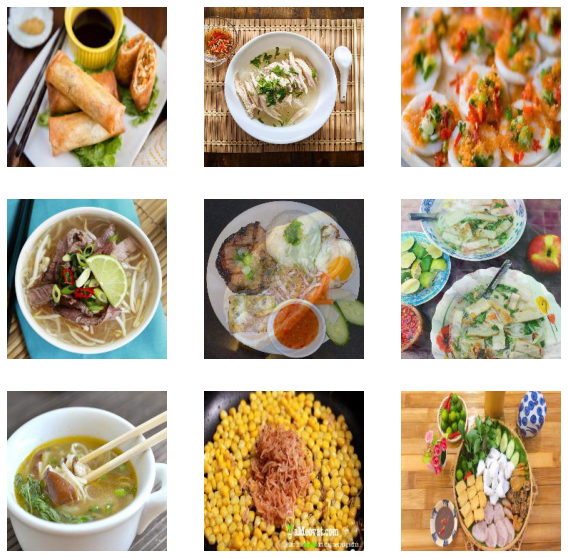

In [23]:
# Let's preview 9 samples from the dataset
sample_images, sample_labels = mixed_img[0]#next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.squeeze())
    print(label.tolist())
    plt.axis("off")